In [1]:
import sys

sys.path.append("/home/dylan-kmutt/ubpd")

In [2]:
from src.helper import get_train_test_pids

train_v_pids, test_pids = get_train_test_pids("../../data/dataset/images/", seed=42)
print(f"Train PIDS: {train_v_pids}")
print(f"Test PIDS: {test_pids}")

Train PIDS: [69, 75, 36, 32, 20, 28, 51, 81, 16, 78, 47, 2, 89, 70, 66, 40, 79, 39, 62, 50, 86, 21, 98, 9, 44, 93, 43, 68, 35, 65, 42, 131, 48, 90, 13, 24, 19, 83, 60, 58, 8, 37, 84, 3, 17, 41, 52, 23, 71, 25, 6, 7, 77, 73, 94, 10, 166, 22, 85, 49, 11, 61, 53, 1, 99, 67, 97, 63, 27, 87, 76, 31, 29, 92]
Test PIDS: [100, 5, 64, 88, 12, 82, 14, 18, 30, 34, 38, 4, 15, 96]


In [3]:
from src.helper import get_cv_pids

cv_folds_pids = get_cv_pids(train_v_pids, cv=5)
for fold, (train_ids, val_ids) in enumerate(cv_folds_pids, start=1):
    print(f"\n📂 Fold {fold}/{len(cv_folds_pids)}")
    print(f"  Train patient IDs: {train_ids}")
    print(f"  Val   patient IDs: {val_ids}")


📂 Fold 1/5
  Train patient IDs: [77, 65, 71, 7, 97, 50, 86, 8, 6, 36, 10, 1, 73, 25, 9, 22, 93, 79, 90, 98, 23, 44, 53, 51, 84, 61, 78, 52, 21, 68, 47, 69, 27, 83, 87, 11, 43, 13, 17, 37, 41, 89, 31, 75, 60, 48, 92, 63, 28, 29, 20, 94, 2, 70, 39, 35, 131, 24, 32, 66]
  Val   patient IDs: [67, 62, 19, 16, 81, 85, 76, 49, 3, 58, 40, 99, 166, 42]

📂 Fold 2/5
  Train patient IDs: [67, 62, 19, 16, 81, 85, 76, 49, 3, 58, 40, 99, 166, 42, 9, 22, 93, 79, 90, 98, 23, 44, 53, 51, 84, 61, 78, 52, 21, 68, 47, 69, 27, 83, 87, 11, 43, 13, 17, 37, 41, 89, 31, 75, 60, 48, 92, 63, 28, 29, 20, 94, 2, 70, 39, 35, 131, 24, 32, 66]
  Val   patient IDs: [77, 65, 71, 7, 97, 50, 86, 8, 6, 36, 10, 1, 73, 25]

📂 Fold 3/5
  Train patient IDs: [67, 62, 19, 16, 81, 85, 76, 49, 3, 58, 40, 99, 166, 42, 77, 65, 71, 7, 97, 50, 86, 8, 6, 36, 10, 1, 73, 25, 21, 68, 47, 69, 27, 83, 87, 11, 43, 13, 17, 37, 41, 89, 31, 75, 60, 48, 92, 63, 28, 29, 20, 94, 2, 70, 39, 35, 131, 24, 32, 66]
  Val   patient IDs: [9, 22, 93, 79,

In [10]:
from src.dataset import UBPDataset
from src.preprocessing import PairedTransform

include_classes = [4]
paired_train_tf = PairedTransform(size=256, aug=True)

cv = get_cv_pids(train_v_pids, cv=5)[0]
train_pids, val_pids = cv[0], cv[1]

train_dataset = UBPDataset(
    p_ids=train_pids,
    include_classes=include_classes,
    image_dir="../../data/dataset/images",
    json_dir="../../data/dataset/labels/json_train",
    joint_transform=paired_train_tf,
    keep_original_indices=True,  # <--- important
)

validation_dataset = UBPDataset(
    p_ids=val_pids,
    include_classes=include_classes,
    image_dir="../../data/dataset/images",
    json_dir="../../data/dataset/labels/json_train",
    joint_transform=paired_train_tf,
    keep_original_indices=True,  # <--- important
)

test_dataset = UBPDataset(
    p_ids=test_pids,
    include_classes=include_classes,
    image_dir="../../data/dataset/images",
    json_dir="../../data/dataset/labels/json_train",
    joint_transform=paired_train_tf,
    keep_original_indices=True,  # <--- important
)

print(f"Len of train: {len(train_dataset)}")
print(f"Len of val: {len(validation_dataset)}")
print(f"Len of test: {len(test_dataset)}")

Len of train: 652
Len of val: 156
Len of test: 147


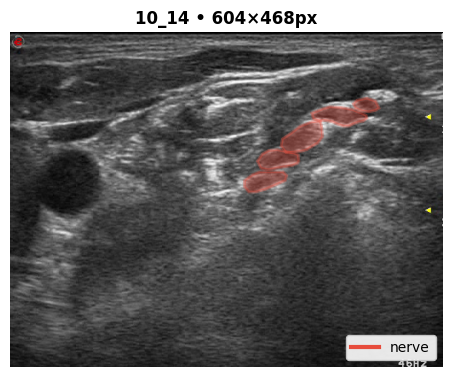

In [14]:
train_dataset.visualize_image(0)

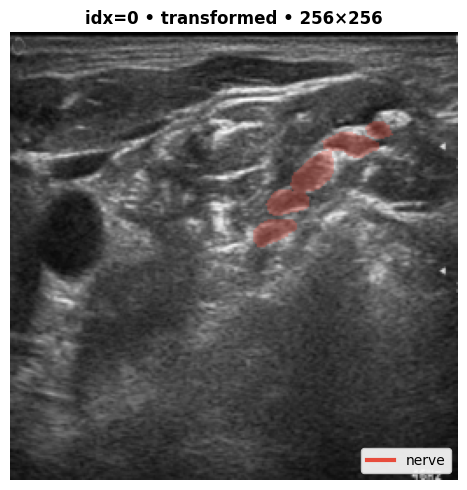

In [41]:
train_dataset.visualize_image_transform(0)

In [7]:
from src.helper import _build_model_factory
from src.train import Trainer

num_classes_for_model = len(include_classes)
variants = {}

n_inc = len(include_classes)
if n_inc == 1:
    variants["loss"] = "bce"
    num_classes_for_model = 1  # single foreground channel
    keep_original_indices = True  # irrelevant when binary
else:
    variants["loss"] = "ce"
    num_classes_for_model = n_inc + 1  # background + selected classes only
    keep_original_indices = False

make_model = _build_model_factory("unet")
model = make_model(num_classes=num_classes_for_model)

trainer = Trainer(
    exp_id="testing",
    fold_num=fold,
    model=model,
    train_dataset=train_dataset,
    val_dataset=validation_dataset,
    arguments=variants,
)
history = trainer.train()

Epoch 001/100 | lr=1.000e-03 train_loss=1.0055 val_loss=0.7133 train_dice=0.0628 val_dice=0.0060 [BEST] (patience 0/10)
Epoch 002/100 | lr=1.000e-03 train_loss=0.5513 val_loss=0.7827 train_dice=0.0994 val_dice=0.1407  (patience 1/10)
Epoch 003/100 | lr=1.000e-03 train_loss=0.4298 val_loss=0.4153 train_dice=0.1363 val_dice=0.1379 [BEST] (patience 0/10)
Epoch 004/100 | lr=1.000e-03 train_loss=0.3789 val_loss=0.3632 train_dice=0.1531 val_dice=0.1648 [BEST] (patience 0/10)
Epoch 005/100 | lr=1.000e-03 train_loss=0.3482 val_loss=0.3805 train_dice=0.1692 val_dice=0.2076  (patience 1/10)
Epoch 006/100 | lr=1.000e-03 train_loss=0.3109 val_loss=0.3492 train_dice=0.2064 val_dice=0.2003 [BEST] (patience 0/10)
Epoch 007/100 | lr=1.000e-03 train_loss=0.2675 val_loss=0.3199 train_dice=0.3062 val_dice=0.3685 [BEST] (patience 0/10)
Epoch 008/100 | lr=1.000e-03 train_loss=0.2527 val_loss=0.3118 train_dice=0.3680 val_dice=0.2964 [BEST] (patience 0/10)
Epoch 009/100 | lr=1.000e-03 train_loss=0.2216 val_l


📊 Dice scores (foreground only):
  Overall (pooled) mean±std: 0.3793 ± 0.3258  (n=556)
  artery               mean±std: 0.2702 ± 0.3255  (median=0.0797, n=126)
  vein                 mean±std: 0.4731 ± 0.3725  (median=0.6765, n=142)
  muscle               mean±std: 0.4244 ± 0.2848  (median=0.4665, n=144)
  nerve                mean±std: 0.3370 ± 0.2762  (median=0.4091, n=144)


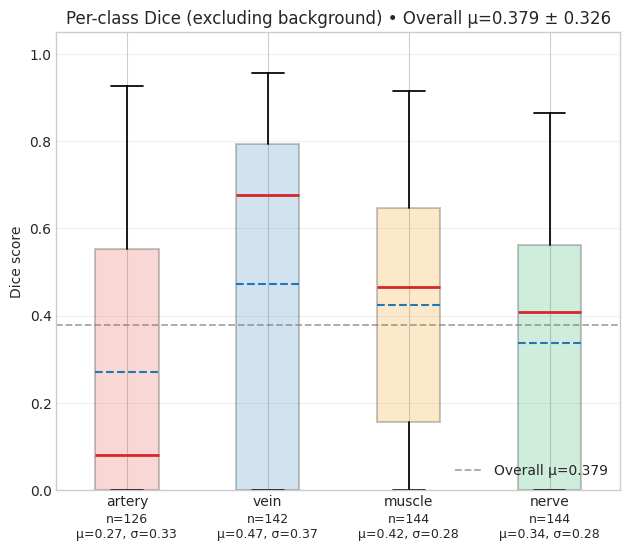

In [8]:
from src.evaluate import Evaluator

# Evaluate one fold (you can move this after the loop to evaluate the final/best model instead)
evaluator = Evaluator(trainer.model, test_dataset, num_classes=num_classes_for_model)
res = evaluator.evaluate_dice_score(show_plot=True)

In [9]:
from src.train_utils import plot_history

plot_history(history)

OSError: 'seaborn-darkgrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)